#### Import necessary libraries

In [158]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#### Load Data

In [159]:
df_links=pd.read_csv('Data/links.csv')
df_movies=pd.read_csv('Data/movies.csv')
df_ratings=pd.read_csv('Data/ratings.csv')
df_tags=pd.read_csv('Data/tags.csv')

#### Understanding the Data

In [160]:
# Explore the links dataset
df_links.head()  # show first few rows

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [161]:
print(df_links.info())          # Get info on data types and non-null counts
print(df_links.describe())     # Summary statistics for numerical columns
print(df_links.isnull().sum())  # Check for missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
None
             movieId        imdbId         tmdbId
count    9742.000000  9.742000e+03    9734.000000
mean    42200.353623  6.771839e+05   55162.123793
std     52160.494854  1.107228e+06   93653.481487
min         1.000000  4.170000e+02       2.000000
25%      3248.250000  9.518075e+04    9665.500000
50%      7300.000000  1.672605e+05   16529.000000
75%     76232.000000  8.055685e+05   44205.750000
max    193609.000000  8.391976e+06  525662.000000
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [162]:
# Explore the movies dataset
df_movies.head()  # show first few rows

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [163]:
print(df_movies.info())          # Get info on data types and non-null counts
print(df_movies.describe())     # Summary statistics for numerical columns
print(df_movies.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000
movieId    0
title      0
genres     0
dtype: int64


In [164]:
# Explore the ratings dataset
df_ratings.head()  # show first few rows

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [165]:
print(df_ratings.info())         # Get info on data types and non-null counts
print(df_ratings.describe())     # Summary statistics for numerical columns
print(df_ratings.isnull().sum()) # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
user

In [166]:
# Explore the tags dataset
df_tags.head()  # show first few rows

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [167]:
print(df_tags.info())         # Get info on data types and non-null counts
print(df_tags.describe())     # Summary statistics for numerical columns
print(df_tags.isnull().sum()) # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None
            userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  1.137521e+09
50%     474.000000    4454.000000  1.269833e+09
75%     477.000000   39263.000000  1.498457e+09
max     610.000000  193565.000000  1.537099e+09
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


#### Handle missing data

In [168]:
df_links = df_links.dropna() # drop missing rows

In [169]:
df_links.isnull().sum() #check the missing data again

movieId    0
imdbId     0
tmdbId     0
dtype: int64

In [170]:
df_links.describe()

,movieId,imdbId,tmdbId
count,9734.000000,9.734000e+03,9734.000000
mean,42215.724471,6.775551e+05,55162.123793
std,52173.928589,1.107581e+06,93653.481487
min,1.000000,4.170000e+02,2.000000
25%,3249.250000,9.518650e+04,9665.500000
50%,7300.000000,1.674155e+05,16529.000000
75%,76282.500000,8.059128e+05,44205.750000
max,193609.000000,8.391976e+06,525662.000000


#### Check for duplicates

In [171]:
# Duplicates in links.csv
df_links.duplicated().sum()

0

In [172]:
# Duplicates in movies.csv
df_movies.duplicated().sum()

0

In [173]:
# Duplicates in ratings.csv
df_ratings.duplicated().sum()

0

In [174]:
# Duplicates in tags.csv
df_tags.duplicated().sum()

0

#### Convert data to correct data types

In [175]:
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'])    # Convert to datetime
df_tags['timestamp'] = pd.to_datetime(df_tags['timestamp'])

In [176]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1970-01-01 00:00:01.445714994
1,2,60756,Highly quotable,1970-01-01 00:00:01.445714996
2,2,60756,will ferrell,1970-01-01 00:00:01.445714992
3,2,89774,Boxing story,1970-01-01 00:00:01.445715207
4,2,89774,MMA,1970-01-01 00:00:01.445715200


#### Handling outliers

In [177]:
from scipy import stats

# Calculate the Z-scores for the column
z_scores = np.abs(stats.zscore(df_ratings['rating']))

# Set a threshold for identifying outliers
threshold = 3

# Find rows where Z-score is greater than the threshold
outliers = df_ratings[z_scores > threshold]
print(outliers)

Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


No outliers detected

#### Deal with Movies.csv genre column

In [178]:
df_movies['genres'] = df_movies['genres'].str.split('|')
df_exploded_movies = df_movies.explode('genres')
df_exploded_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy
...,...,...,...
9738,193583,No Game No Life: Zero (2017),Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Animation


#### One-hot encoding

In [179]:
# Pivot to create a one-hot encoded DataFrame for genres
genres_encoding = df_exploded_movies.pivot_table(index='movieId', columns='genres', aggfunc=lambda x: 1, fill_value=0)

# Flatten the multi-level column index resulting from pivot to get simple column names
genres_encoding.columns = genres_encoding.columns.get_level_values(1)
genres_encoding = genres_encoding.add_prefix('genre_')

# Merge the one-hot encoded genres with the original movies DataFrame 
df_movies_encoded = pd.merge(df_movies.drop(columns='genres').drop_duplicates(), genres_encoding, on='movieId', how='left')

df_movies_encoded

,movieId,title,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Merge the data

In [180]:
df_ratings_movies_merged= pd.merge(df_movies_encoded, df_ratings, on='movieId', how='inner') # merge ratings.csv with movies.csv
df_ratings_movies_merged

,movieId,title,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,userId,rating,timestamp
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,4.0,1970-01-01 00:00:00.964982703
1,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,5,4.0,1970-01-01 00:00:00.847434962
2,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,7,4.5,1970-01-01 00:00:01.106635946
3,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,15,2.5,1970-01-01 00:00:01.510577970
4,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,17,4.5,1970-01-01 00:00:01.305696483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,184,4.0,1970-01-01 00:00:01.537109082
100832,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,184,3.5,1970-01-01 00:00:01.537109545
100833,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,184,3.5,1970-01-01 00:00:01.537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,184,3.5,1970-01-01 00:00:01.537110021


In [181]:
df_merged=pd.merge(df_ratings_movies_merged, df_tags, on=['movieId', 'userId'], how='left')
df_merged

,movieId,title,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,userId,rating,timestamp_x,tag,timestamp_y
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,1,4.0,1970-01-01 00:00:00.964982703,NaN,NaT
1,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,5,4.0,1970-01-01 00:00:00.847434962,NaN,NaT
2,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,7,4.5,1970-01-01 00:00:01.106635946,NaN,NaT
3,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,15,2.5,1970-01-01 00:00:01.510577970,NaN,NaT
4,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,17,4.5,1970-01-01 00:00:01.305696483,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102672,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,184,4.0,1970-01-01 00:00:01.537109082,NaN,NaT
102673,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,184,3.5,1970-01-01 00:00:01.537109545,NaN,NaT
102674,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,184,3.5,1970-01-01 00:00:01.537109805,NaN,NaT
102675,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,184,3.5,1970-01-01 00:00:01.537110021,NaN,NaT


#### Deal with the NaN values in tags

In [182]:
# Create a binary indicator column for the presence of tags
df_merged['tag_present'] = df_merged['tag'].notna().astype(int)

df_merged.head()

,movieId,title,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,userId,rating,timestamp_x,tag,timestamp_y,tag_present
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,1,4.0,1970-01-01 00:00:00.964982703,NaN,NaT,0
1,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,5,4.0,1970-01-01 00:00:00.847434962,NaN,NaT,0
2,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,7,4.5,1970-01-01 00:00:01.106635946,NaN,NaT,0
3,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,15,2.5,1970-01-01 00:00:01.510577970,NaN,NaT,0
4,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,17,4.5,1970-01-01 00:00:01.305696483,NaN,NaT,0


##### Refine the User-Item Matrix

In [183]:
user_item_matrix = df_merged.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import scipy.sparse as sparse


# Convert the user-item matrix to a sparse matrix format and ensure data is float
user_item_matrix_sparse = sparse.csr_matrix(user_item_matrix_filled.values.astype(float))

# Apply SVD on the sparse matrix
U, sigma, Vt = svds(user_item_matrix_sparse, k=50)
sigma = np.diag(sigma)

# Reconstruct the predicted ratings matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert back to DataFrame for further analysis
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Print the predicted ratings to verify
print(predicted_ratings_df.head())

movieId    1         2         3         4         5         6         7       \
userId                                                                          
1        2.181872  0.393674  0.838186 -0.082365 -0.546279  2.521662 -0.887231   
2        0.209809  0.004821  0.030742  0.017252  0.183764 -0.060660  0.083306   
3        0.013394  0.034726  0.050525  0.000200 -0.005577  0.114673 -0.007461   
4        2.012072 -0.394882 -0.290386  0.093864  0.123312  0.259765  0.472667   
5        1.336714  0.772954  0.064577  0.113880  0.274994  0.584480  0.251048   

movieId    8         9         10      ...    193565    193567    193571  \
userId                                 ...                                 
1       -0.025221  0.196969  1.606758  ... -0.024984 -0.021415 -0.028553   
2        0.023797  0.048100 -0.151968  ...  0.018895  0.016196  0.021594   
3        0.000738  0.004747 -0.061284  ... -0.001612 -0.001382 -0.001843   
4        0.035965  0.011293 -0.021983  ...  0.001966

### Visualizations

c:\Users\DAVE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


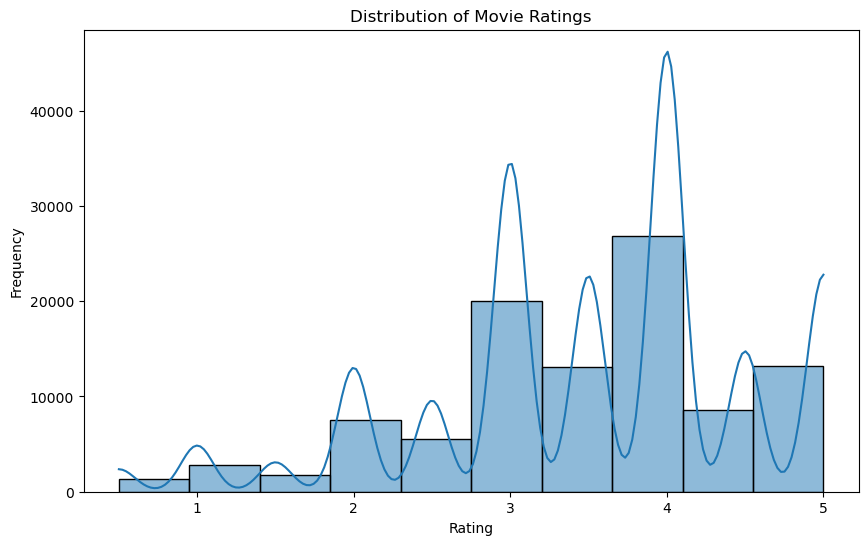

In [185]:
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

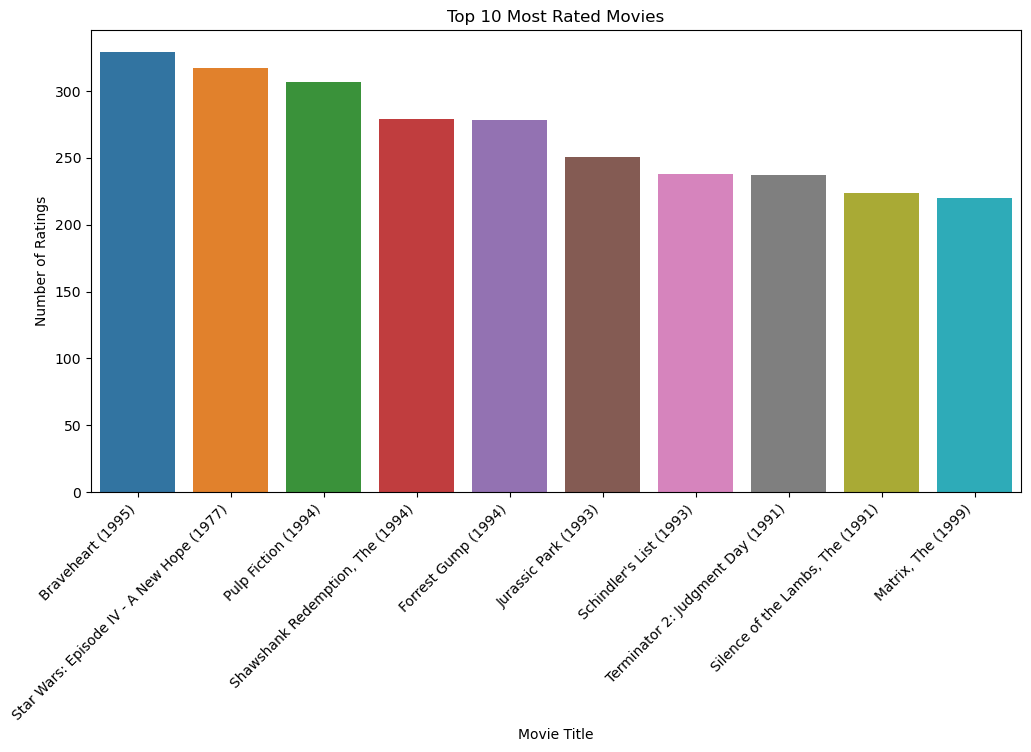

In [186]:
most_rated = df_ratings.groupby('movieId').size().nlargest(10)
most_rated_movies = df_movies[df_movies['movieId'].isin(most_rated.index)]

plt.figure(figsize=(12, 6))
sns.barplot(x='title', y=most_rated.values, data=most_rated_movies)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.show()

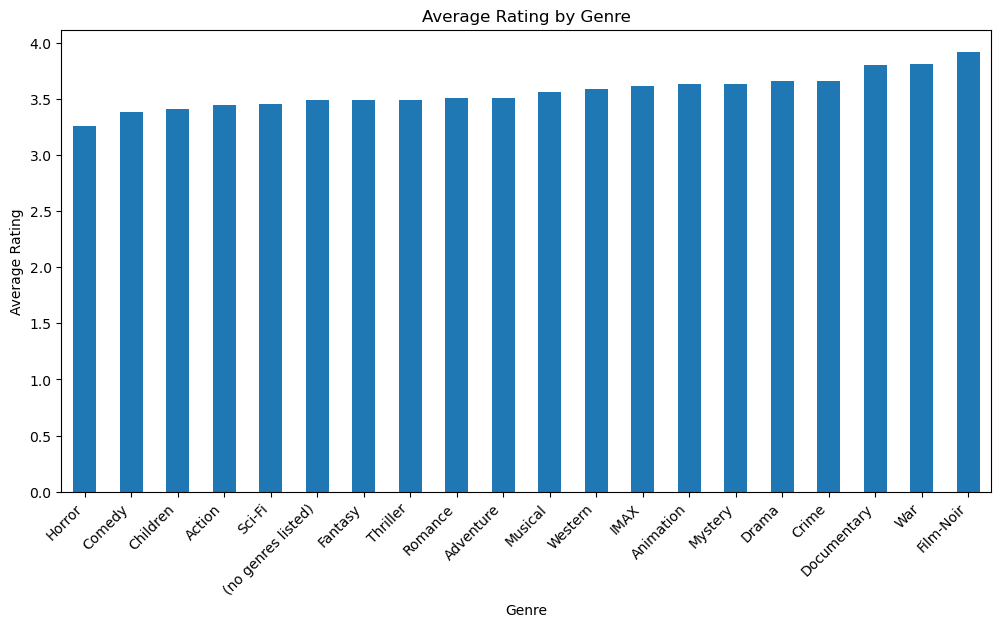

In [187]:
avg_genre_ratings = df_exploded_movies.merge(df_ratings, on='movieId').groupby('genres')['rating'].mean().sort_values()

plt.figure(figsize=(12, 6))
avg_genre_ratings.plot(kind='bar')
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

c:\Users\DAVE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


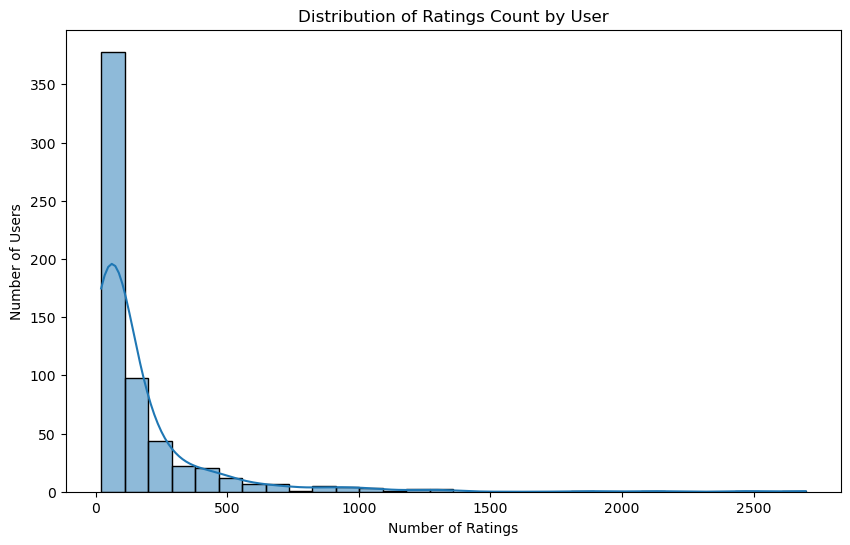

In [188]:
ratings_count_by_user = df_ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_count_by_user, bins=30, kde=True)
plt.title('Distribution of Ratings Count by User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

#### Build the Recommendation Model with SVD

In [189]:
def recommend_movies(predicted_ratings_df, user_id, movies_df, num_recommendations=5):
    # Get and sort the user's predicted ratings
    user_pred_ratings = predicted_ratings_df.loc[user_id].sort_values(ascending=False)
    
    # Filter out movies the user has already rated
    user_rated_movies = user_item_matrix.loc[user_id].dropna().index
    recommendations = user_pred_ratings.drop(index=user_rated_movies).head(num_recommendations)
    
    # Return the movie titles for the top recommendations
    return movies_df[movies_df['movieId'].isin(recommendations.index)][['movieId', 'title']]

Apply the Recommendation Function

In [190]:
user_id = 2  # Replace with any user ID from your dataset
recommendations = recommend_movies(predicted_ratings_df, user_id, df_movies, num_recommendations=5)
print(recommendations)

      movieId                       title
314       356         Forrest Gump (1994)
1939     2571          Matrix, The (1999)
2226     2959           Fight Club (1999)
7413    80463  Social Network, The (2010)
8879   134130          The Martian (2015)


#### Evaluate the Model
Lets use regression metrics like RMSE and MAE

In [194]:
# drop the NaNs for comparison
predicted_ratings_filled = predicted_ratings_df[user_item_matrix.notna()]
actual_ratings = user_item_matrix[user_item_matrix.notna()]

actual_ratings_no_nan = actual_ratings.dropna()
predicted_ratings_no_nan = predicted_ratings_filled.dropna()

# If dropping leads to mismatched indices, align the matrices before evaluating
actual_ratings_aligned, predicted_ratings_aligned = actual_ratings_no_nan.align(predicted_ratings_no_nan, join='inner', axis=0)

In [196]:
print(actual_ratings_aligned.shape)
print(predicted_ratings_aligned.shape)

(0, 9724)
(0, 9724)


In [197]:
# Verify Alignment
actual_ratings_no_nan, predicted_ratings_no_nan = actual_ratings.align(predicted_ratings_filled, join='inner', axis=0)

In [198]:
# Instead of dropping NaNs, fill them with a specific value
actual_ratings_filled = actual_ratings.fillna(0)
predicted_ratings_filled = predicted_ratings_filled.fillna(0)

actual_ratings_aligned, predicted_ratings_aligned = actual_ratings_filled.align(predicted_ratings_filled, join='inner', axis=0)

In [199]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Optionally fill NaNs (or handle as per project context)
actual_ratings_filled = actual_ratings.fillna(0)
predicted_ratings_filled = predicted_ratings_filled.fillna(0)

# Align the dataframes and check shape
actual_ratings_aligned, predicted_ratings_aligned = actual_ratings_filled.align(predicted_ratings_filled, join='inner', axis=0)
print(actual_ratings_aligned.shape, predicted_ratings_aligned.shape)

# Calculate RMSE and MAE only if the DataFrames are non-empty
if actual_ratings_aligned.shape[0] > 0:
    rmse = np.sqrt(mean_squared_error(actual_ratings_aligned, predicted_ratings_aligned))
    mae = mean_absolute_error(actual_ratings_aligned, predicted_ratings_aligned)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
else:
    print("Error: No overlapping ratings between actual and predicted data. Ensure proper alignment or handling of missing values.")

(610, 9724) (610, 9724)
RMSE: 0.2604663044045019
MAE: 0.026063207638909774


Apply the Recommendation Function

In [201]:
user_id = 5  # Replace with any user ID from your dataset
recommendations = recommend_movies(predicted_ratings_df, user_id, df_movies, num_recommendations=5)
print(recommendations)

     movieId                             title
134      161               Crimson Tide (1995)
314      356               Forrest Gump (1994)
334      377                      Speed (1994)
418      480              Jurassic Park (1993)
510      593  Silence of the Lambs, The (1991)
